In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import os, urllib
import mlflow, git

from stable_baselines.common.cmd_util import make_vec_env
from stable_baselines.common.vec_env import VecNormalize

import matplotlib.pyplot as plt
%matplotlib inline

from lib import eos
from lib.eos import EyeOnStickEnv

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
from PIL import Image, ImageDraw
from IPython import display
from io import BytesIO

def showarray(img_array):
    buf = BytesIO()
    Image.fromarray(np.uint8(img_array)).save(buf, 'png')
    display.display(display.Image(data=buf.getvalue()))

In [3]:
#assert not git.Repo().is_dirty()

In [4]:
env = make_vec_env(lambda: EyeOnStickEnv(), n_envs=eos.N_ENVS)
env = VecNormalize(env)

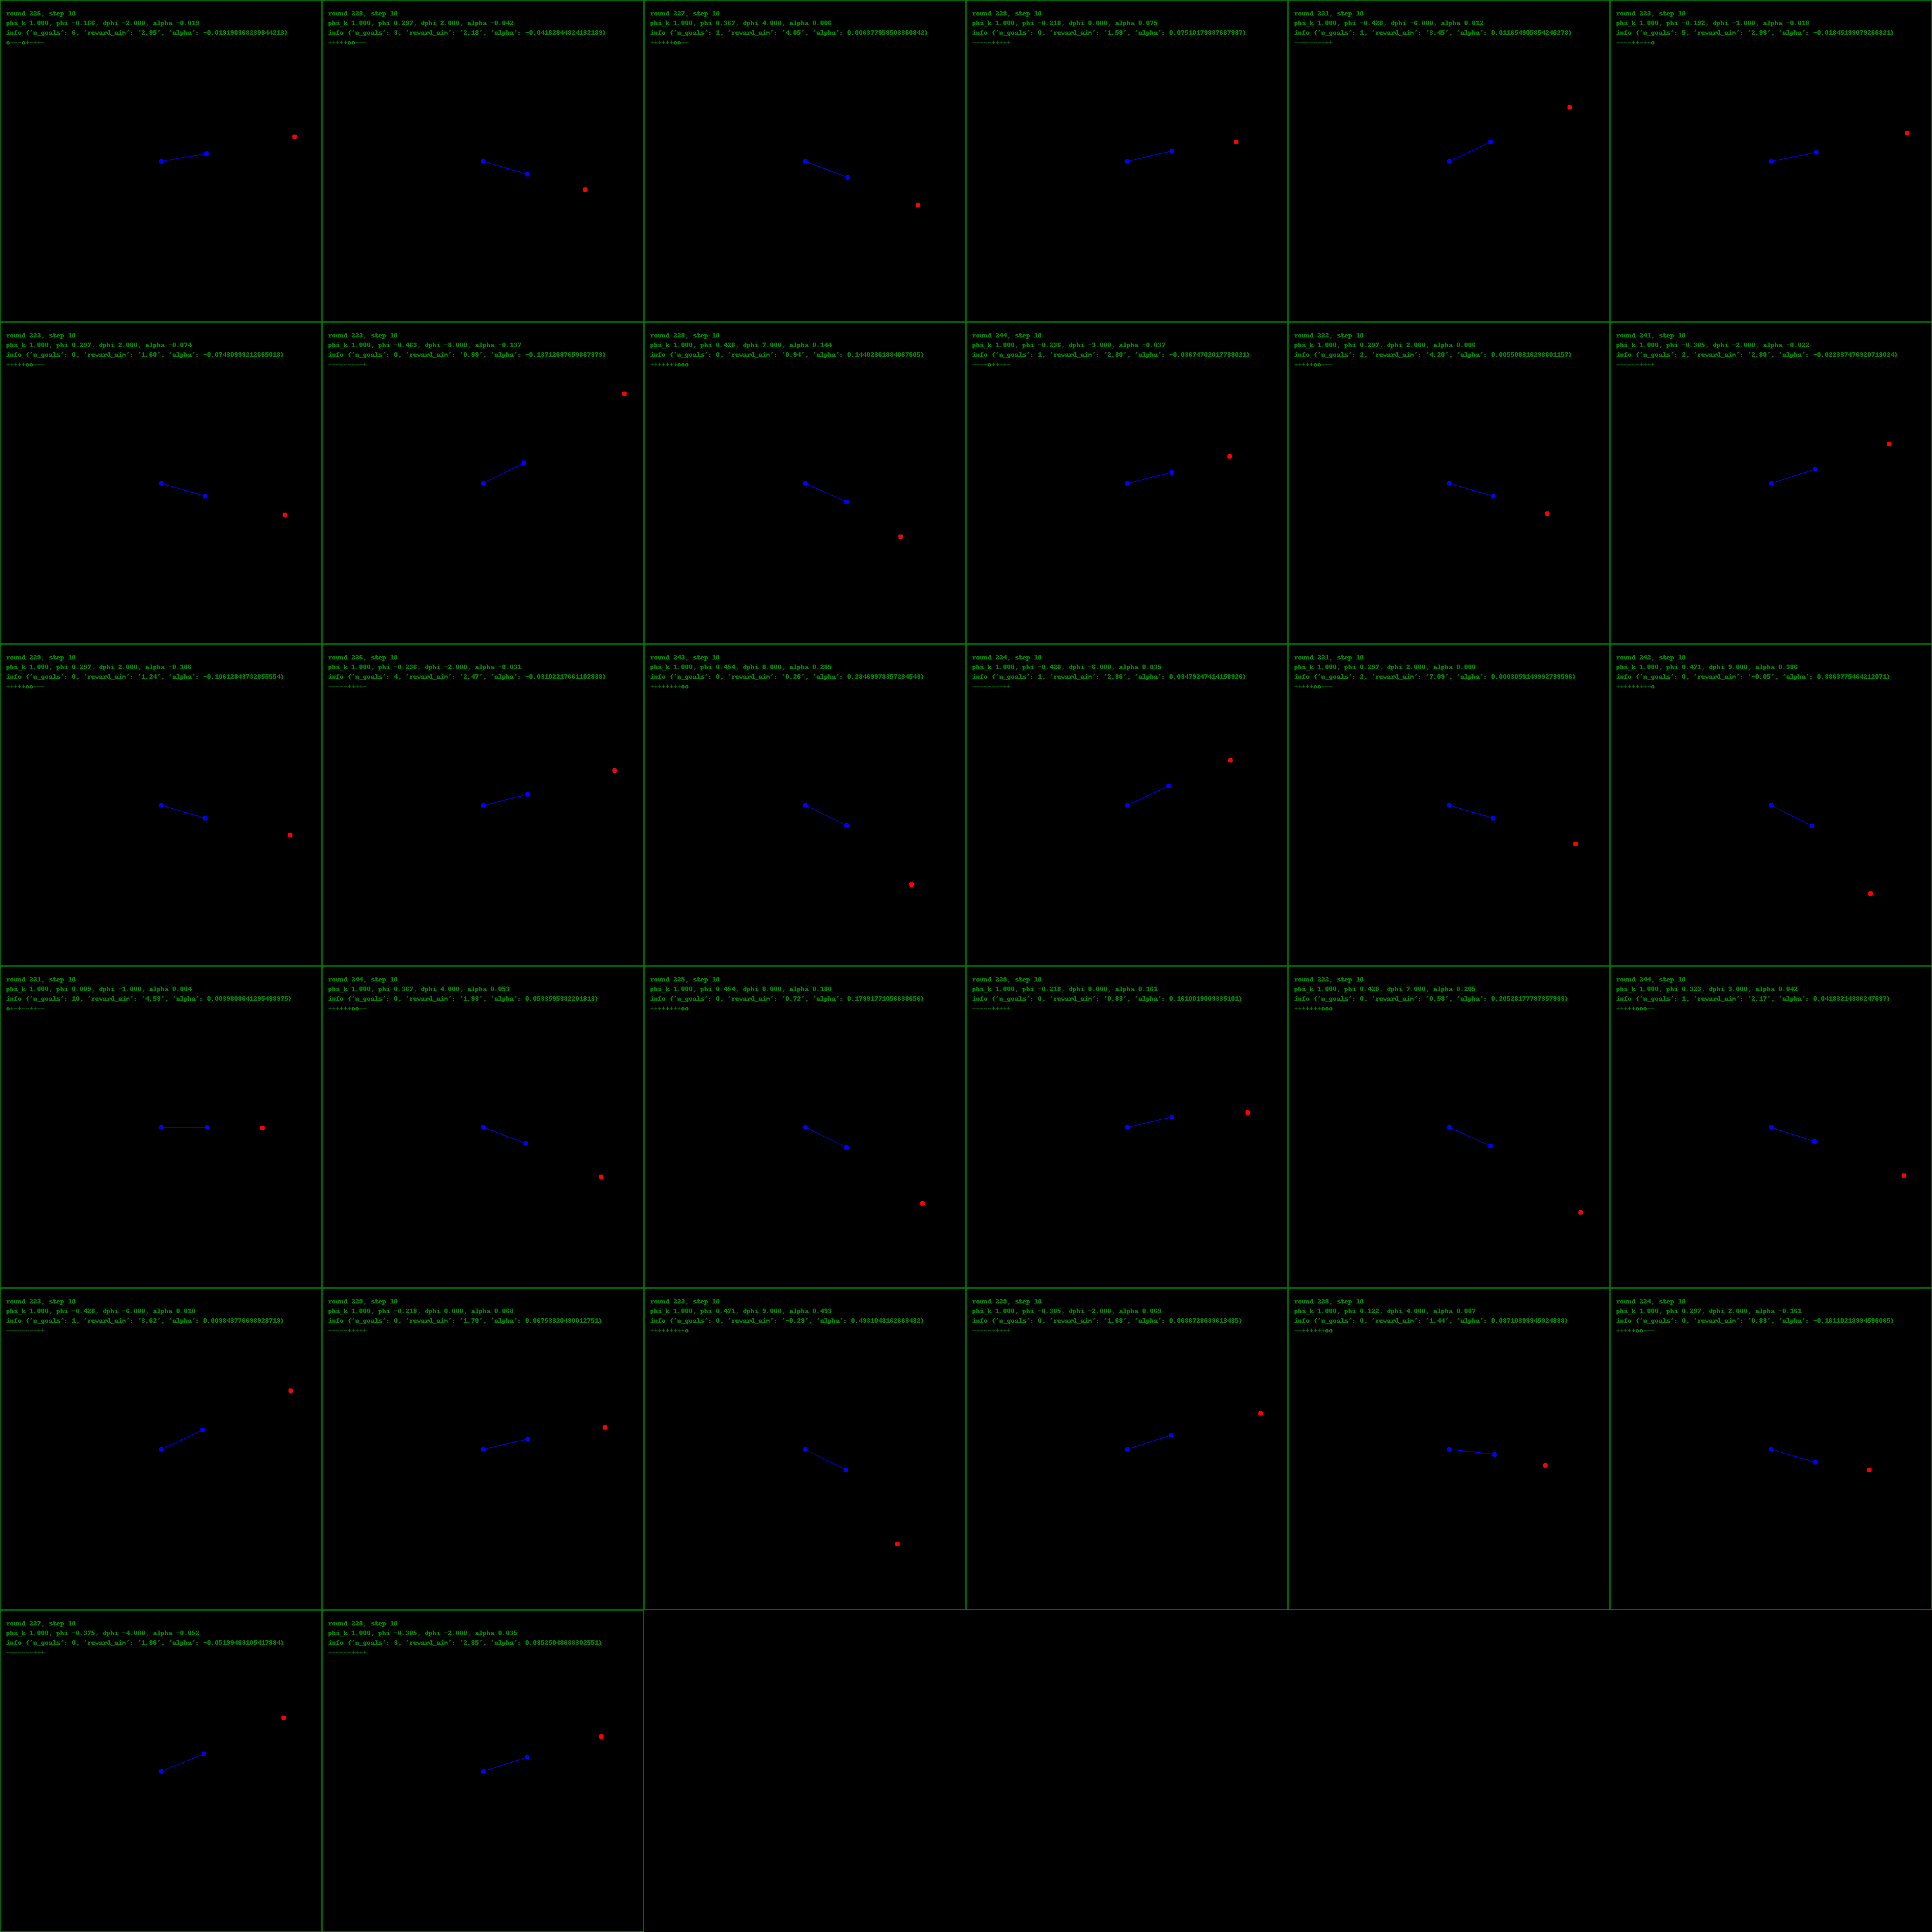

In [ ]:
with mlflow.start_run(run_name='eye-on-stick neglog nogoals refactor') as parent_run:
    mlflow_artifacts_dir = urllib.request.url2pathname(urllib.parse.urlparse(mlflow.get_artifact_uri()).path)
    
    mlflow.log_param("policy_class", eos.POLICY_CLASS.__name__)
    mlflow.log_param("model_name", eos.MODEL_NAME)
    mlflow.log_param("n_goals", eos.N_GOALS)
    mlflow.log_param("reward_aim_clip", eos.REWARD_AIM_CLIP)

    tensorboard_logdir = os.path.join(mlflow_artifacts_dir, "tensorboard_log")
    os.makedirs(tensorboard_logdir, exist_ok=False)
    
    model = eos.POLICY_CLASS(eos.MODEL_NAME, env, verbose=1, tensorboard_log=tensorboard_logdir)
    
    for era in range(1000000000): # FIXME
        with mlflow.start_run(run_name=f'era={era}', nested=True) as child_run:
            total_reward = 0
            alphas = []

            obs = env.env_method('reset', reset_pose=True)

            for _ in range(eos.N_STEPS):
                display.clear_output(wait=True)
                showarray(env.render(mode='rgb_array'))

                actions, _ = model.predict(obs, deterministic=True)
                obs, rewards, _dones, infos = env.step(actions)
                
                total_reward += np.sum(rewards)
                alphas.append([info['alpha'] for info in infos])                
            
            mlflow.log_metric(key="alpha_mean", value=np.mean(alphas), step=era)
            mlflow.log_metric(key="alpha_std", value=np.std(alphas), step=era)
            mlflow.log_metric(key="total_reward", value=total_reward, step=era)

            model.learn(eos.N_LEARN_EPOCHS)
            #mlflow.keras.save_model(model, f"era{era}")
 
    env.close()